# PyTorch Quickstart
In this code tutorial we will learn how to quickly train a model to understand some of PyTorch's basic building blocks to train a deep learning model. After completion of this tutorial, you should be able to import data, transform it, and efficiently feed the data in batches to a convolution neural network (CNN) model for image classification.

This quickstart was adapted from [dair-ai's notebook](https://github.com/dair-ai/pytorch_notebooks/blob/master/pytorch_quick_start.ipynb).

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [16]:
print(torch.__version__)

2.4.1


## Import The Data
The first step before training the model is to import the data. We will use the [MNIST dataset](http://yann.lecun.com/exdb/mnist/) which is like the Hello World dataset of machine learning. 

Besides importing the data, we will also do a few more things:
- We will tranform the data into tensors using the `transforms` module
- We will use `DataLoader` to build convenient data loaders or what are referred to as iterators, which makes it easy to efficiently feed data in batches to deep learning models. 
- As hinted above, we will also create batches of the data by setting the `batch` parameter inside the data loader. Notice we use batches of `32` in this tutorial but you can change it to `64` if you like. I encourage you to experiment with different batches.

In [17]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose(
    [transforms.ToTensor()])

## download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=2)

## Exploring the Data
As a practioner and researcher, I am always spending a bit of time and effort exploring and understanding the dataset. It's fun and this is a good practise to ensure that everything is in order. 

Let's check what the train and test dataset contains. I will use `matplotlib` to print out some of the images from our dataset. 

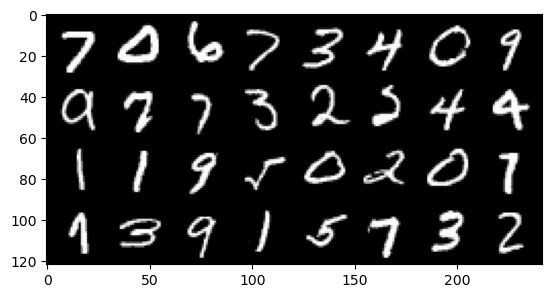

In [21]:
import matplotlib.pyplot as plt
import numpy as np

## functions to show an image
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

## show images
imshow(torchvision.utils.make_grid(images))

Let's check the dimensions of a batch.

In [35]:
for images, labels in trainloader:
    print("Image batch dimensions:", images.shape)
    print("Image label dimensions:", labels.shape)
    break

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])
tensor([2, 0, 0, 5, 0, 7, 2, 0, 9, 0, 8, 4, 8, 4, 1, 4, 6, 3, 3, 0, 4, 5, 7, 9,
        4, 0, 6, 7, 4, 8, 3, 3])


## The Model
Now using the classical deep learning framework pipeline, let's build the 1 convolutional layer model. 

Here are a few notes for those who are beginning with PyTorch:
- The model below consists of an `__init__()` portion which is where you include the layers and components of the neural network. In our model, we have a convolutional layer denoted by `nn.Conv2d(...)`. We are dealing with an image dataset that is in a grayscale so we only need one channel going in, hence `in_channels=1`. We hope to get a nice representation of this layer, so we use `out_channels=32`. Kernel size is 3, and for the rest of parameters we use the default values which you can find [here](https://pytorch.org/docs/stable/nn.html?highlight=conv2d#conv2d). 
- We use 2 back to back dense layers or what we refer to as linear transformations to the incoming data. Notice for `d1` I have a dimension which looks like it came out of nowhere. 128 represents the size we want as output and the (`26*26*32`) represents the dimension of the incoming data. If you would like to find out how to calculate those numbers refer to the [PyTorch documentation](https://pytorch.org/docs/stable/nn.html?highlight=linear#conv2d). In short, the convolutional layer transforms the input data into a specific dimension that has to be considered in the linear layer. The same applies for the second linear transformation (`d2`) where the dimension of the output of the previous linear layer was added as `in_features=128`, and `10` is just the size of the output which also corresponds to the number of classes.
- After each one of those layers, we also apply an activation function such as `ReLU`. For prediction purposes, we then apply a `softmax` layer to the last transformation and return the output of that.  

In [25]:
import torch.nn as nn
import torch.nn.functional as F

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # Define the first convolutional layer
        # Input: 28x28x1 (grayscale image)
        # Output: 32x26x26 (after applying 3x3 kernel, with 32 filters)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)

        # Define the first fully connected layer (dense layer)
        # Input size is the flattened output from the convolutional layer (32 * 26 * 26)
        # Output size is 128 (reduced dimensionality for further processing)
        self.d1 = nn.Linear(32 * 26 * 26, 128)

        # Define the second fully connected layer (output layer)
        # Input size is 128
        # Output size is 10 (representing 10 classes, for example, digits 0-9)
        self.d2 = nn.Linear(128, 10)

    def forward(self, x):
        # Apply the convolutional layer to input x
        # Input shape: (batch_size, 1, 28, 28)
        # Output shape after conv1: (batch_size, 32, 26, 26)
        x = self.conv1(x)
        # Apply ReLU activation function for non-linearity
        x = F.relu(x)

        # Flatten the output from the convolutional layer
        # Flatten starting from dimension 1, to preserve the batch size
        # Input shape: (batch_size, 32, 26, 26)
        # Output shape: (batch_size, 32 * 26 * 26)
        x = x.flatten(start_dim=1)

        # Apply the first fully connected layer
        # Input shape: (batch_size, 32 * 26 * 26)
        # Output shape: (batch_size, 128)
        x = self.d1(x)
        # Apply ReLU activation function for non-linearity
        x = F.relu(x)

        # Apply the second fully connected layer (logits layer)
        # Input shape: (batch_size, 128)
        # Output shape: (batch_size, 10)
        logits = self.d2(x)

        # Apply softmax activation function to get class probabilities
        # The output shape will be (batch_size, 10), with each value representing the probability of each class
        out = F.softmax(logits, dim=1)
        return out

In [26]:
## test the model with 1 batch
model = MyModel()
for images, labels in trainloader:
    print("batch size:", images.shape)
    out = model(images)
    print(out.shape)
    break

batch size: torch.Size([32, 1, 28, 28])
torch.Size([32, 10])


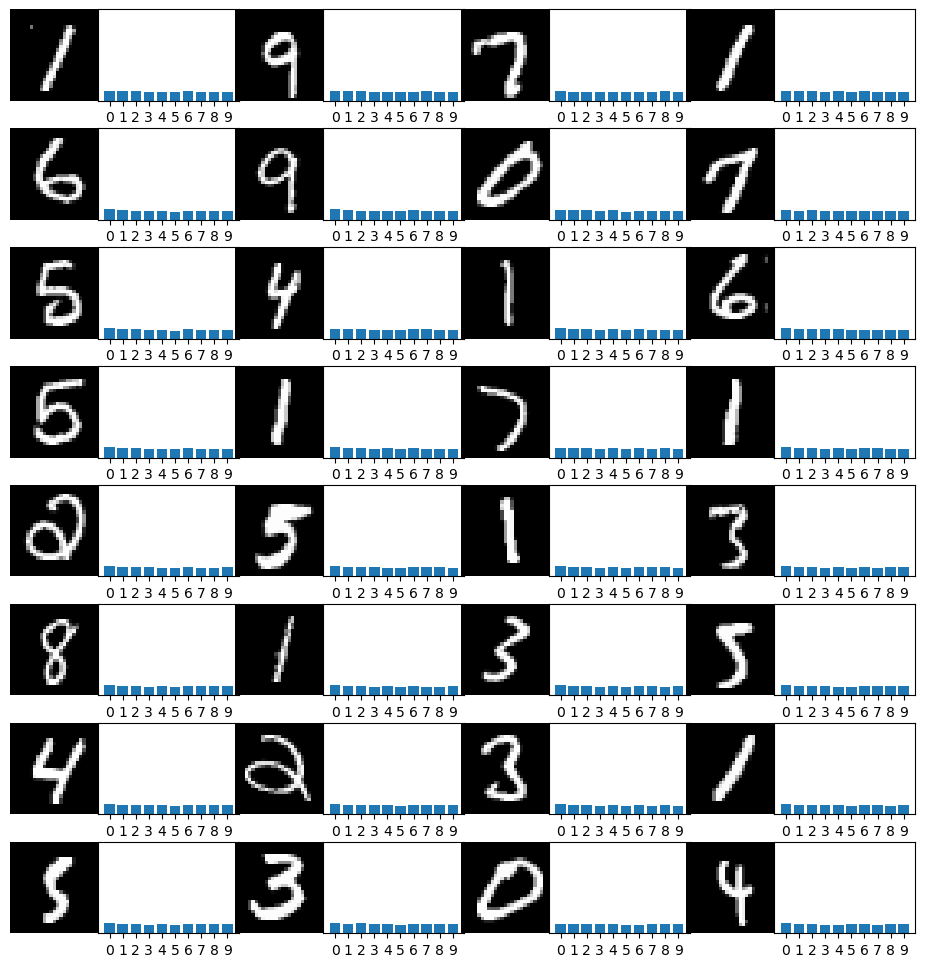

In [27]:
# Take a look at the results!

import matplotlib.pyplot as plt
import numpy as np

# Define the number of images per row
n_cols = 4
n_rows = 8  # Since we have 32 images, 32 / 4 = 8 rows

# Make a figure with a grid of subplots
fig, axs = plt.subplots(n_rows, n_cols*2, figsize=(12, 12))

for i in range(32):
    row = i // n_cols
    col = (i % n_cols) * 2

    # Plot the image
    axs[row, col].imshow(images[i].squeeze(), cmap="gray")
    axs[row, col].axis('off')

    # Plot the bar chart of probabilities
    axs[row, col + 1].bar(np.arange(10), out[i].detach().numpy())
    axs[row, col + 1].set_xticks(np.arange(10))
    axs[row, col + 1].set_ylim([0, 1])  # Probabilities between 0 and 1
    axs[row, col + 1].set_yticks([])

# Remove space between subplots
plt.subplots_adjust(wspace=-.2, hspace=0.3)

plt.show()


## Training the Model
Now we are ready to train the model but before that we are going to setup a loss function, an optimizer and a function to compute accuracy of the model. 

As is common for classifiers, we'll train using cross-entropy loss. This is a measure of the difference between two probability distributions: the true labels ($y$) and the predicted probabilities ($\hat{y}$). The formula for cross-entropy loss is:

$$
L(y, \hat{y}) = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$

where $C$ is the number of classes, $y_i$ is the true label (0 or 1), and $\hat{y}_i$ is the predicted probability for class $i$.


In [28]:
learning_rate = 0.001
num_epochs = 5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

Now it's time for training.

In [30]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))        

Epoch: 0 | Loss: 1.6622 | Train Accuracy: 80.17
Epoch: 1 | Loss: 1.4965 | Train Accuracy: 96.85
Epoch: 2 | Loss: 1.4832 | Train Accuracy: 98.06
Epoch: 3 | Loss: 1.4781 | Train Accuracy: 98.52
Epoch: 4 | Loss: 1.4747 | Train Accuracy: 98.84


We can also compute accuracy on the testing dataset to see how well the model performs on the image classification task. As you can see below, our basic CNN model is performing very well on the MNIST classification task.

In [31]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 98.27


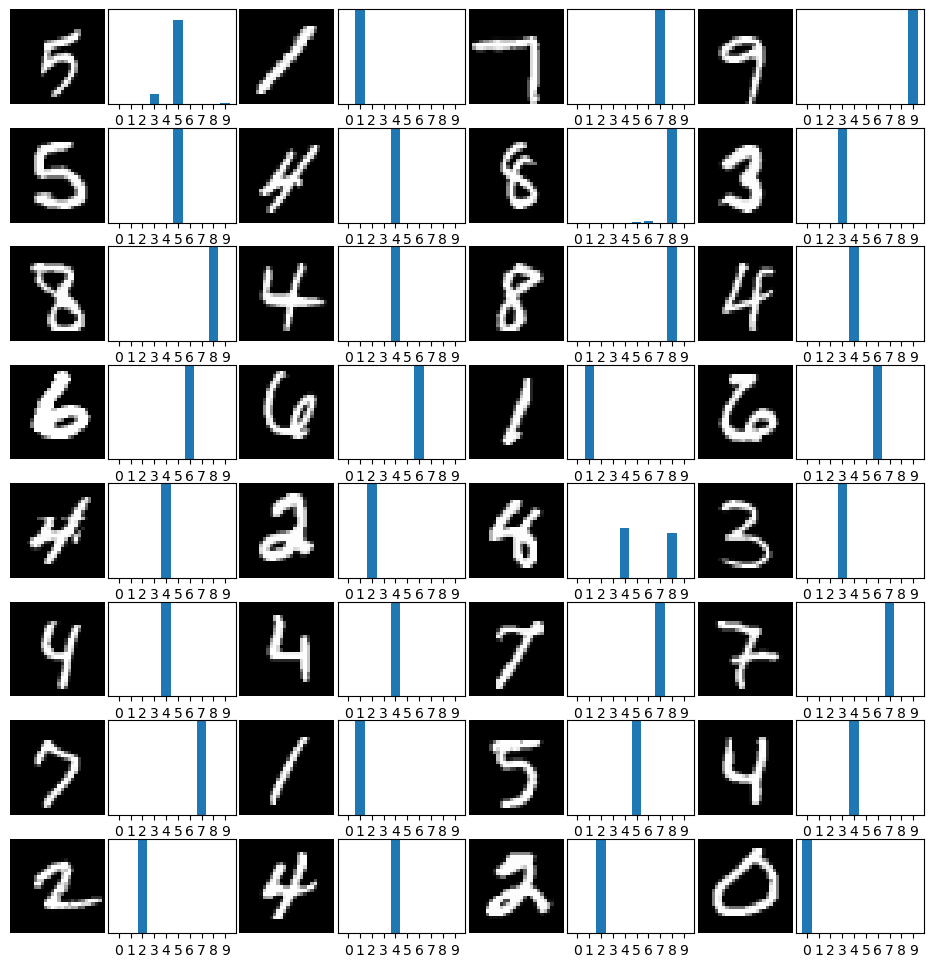

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Get a random batch from testloader by iterating
for images, labels in testloader:
    outputs = model(images.to(device))
    
    images = images.cpu()
    outputs = outputs.cpu()
    
    # Define the number of images per row
    n_cols = 4
    n_rows = int(images.shape[0] / n_cols)

    # Make a figure with a grid of subplots
    fig, axs = plt.subplots(n_rows, n_cols*2, figsize=(12, 12))

    for i in range(n_cols * n_rows):
        row = i // n_cols
        col = (i % n_cols) * 2

        # Plot the image
        axs[row, col].imshow(images[i].squeeze(), cmap="gray")
        axs[row, col].axis('off')

        # Plot the bar chart of probabilities
        axs[row, col + 1].bar(np.arange(10), outputs[i].detach().numpy())
        axs[row, col + 1].set_xticks(np.arange(10))
        axs[row, col + 1].set_ylim([0, 1])  # Probabilities between 0 and 1
        axs[row, col + 1].set_yticks([])

    # Remove space between subplots
    plt.subplots_adjust(wspace=-.1, hspace=.25)
    
    # Show the batch visualization
    plt.show()

    break  # Break after displaying one batch


## Final Words
That's it for this tutorial! Congratulations! You are now able to implement a basic CNN model in PyTorch for image classification. If you would like, you can further extend the CNN model by adding more convolution layers and max pooling, but as you saw, you don't really need it here as results look good. If you are interested in implementing a similar image classification model using RNNs see the references below. 